In [42]:
import numpy as np
import pandas as pd
import pylab as pl
import statsmodels.api as sm
import os
import scipy.stats as stats
import scipy.optimize as optimize

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
### A function to download the data in case it's not there yet. 

def getCitiBikeCSV(datestring):
    '''
    Function that looks for a csv file with citibike data corresponding to the datestring in the PUIdata directory.
    If csv file is not there, looks for the corresponding zip file. If the zip file is there unzip it.
    If the zip file is not there either, the function downloads it from the citibike website and then unzip it. 
    '''
    
    print('Looking for the citibike data for the month ' + datestring + "...")
    
    ### First check if the csv file is not already at the directory
    if os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("CSV File was already at the PUIdata directory.")
        
    # If the CSV is not there, now check if the ZIP File is already there.
    # If the ZIP File is there, unzip it and move the unzipped CSV to the PUIdata directory
    elif os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
            print('ZIP File was already at the PUIdata directory.')
            
            # unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            print('CSV File unzipped.')
            
            # Move the CSV to the PUIdata directory
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    
    else :
        # Download the Zip File; move it to the PUIdata directory; unzip it; move the csv to the PUIdata directory.
        print ("Downloading", datestring)
        
        # Downloading the ZIP File
        os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
        print ("ZIP File downloaded.")
        
        # Moving it to the PUIdata directory
        os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
        
        # unzip the csv 
        os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
        
        # and move it to the PUIdata directory
        os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
           
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("CSV File in place, you can continue.\n")

In [26]:
datestring = '201508'
getCitiBikeCSV(datestring)

Looking for the citibike data for the month 201508...
CSV File was already at the PUIdata directory.
CSV File in place, you can continue.



In [27]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1202,8/1/2015 00:00:04,8/1/2015 00:20:07,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,23253,Subscriber,1987.0,1
1,301,8/1/2015 00:00:05,8/1/2015 00:05:06,450,W 49 St & 8 Ave,40.762272,-73.987882,479,9 Ave & W 45 St,40.760193,-73.991255,22675,Subscriber,1951.0,2
2,431,8/1/2015 00:00:06,8/1/2015 00:07:18,312,Allen St & E Houston St,40.722055,-73.989111,296,Division St & Bowery,40.714131,-73.997047,19831,Subscriber,1985.0,1
3,273,8/1/2015 00:00:09,8/1/2015 00:04:43,382,University Pl & E 14 St,40.734927,-73.992005,229,Great Jones St,40.727434,-73.993790,22765,Subscriber,1975.0,1
4,1256,8/1/2015 00:00:17,8/1/2015 00:21:13,352,W 56 St & 6 Ave,40.763406,-73.977225,432,E 7 St & Avenue A,40.726218,-73.983799,22127,Subscriber,1978.0,1


In [28]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [29]:
#df is the dataframe where the content of the csv file is stored
df['age'] = 2015 - df['birth year'][(df['usertype'] == 'Subscriber')]


In [30]:
#dropping some data I no longer need
df.drop([u'tripduration', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude',
         u'starttime', u'stoptime', u'bikeid'], axis=1, inplace=True)
df.head()

,usertype,birth year,gender,age
0,Subscriber,1987.0,1,28.0
1,Subscriber,1951.0,2,64.0
2,Subscriber,1985.0,1,30.0
3,Subscriber,1975.0,1,40.0
4,Subscriber,1978.0,1,37.0


In [31]:
df.dropna(inplace = True)
df.describe()

,birth year,gender,age
count,958043.000000,958043.000000,958043.000000
mean,1977.144026,1.244938,37.855974
std,11.337429,0.433267,11.337429
min,1885.000000,0.000000,16.000000
25%,1970.000000,1.000000,29.000000
50%,1980.000000,1.000000,35.000000
75%,1986.000000,1.000000,45.000000
max,1999.000000,2.000000,130.000000


In [32]:
# cleaning outliers: age > 95. 
df = df[df['age'] <= 95]

# grouping by age
df.groupby('age').count().head()


,usertype,birth year,gender
age,,,
16.0,281,281,281
17.0,1334,1334,1334
18.0,1492,1492,1492
19.0,2153,2153,2153
20.0,3353,3353,3353


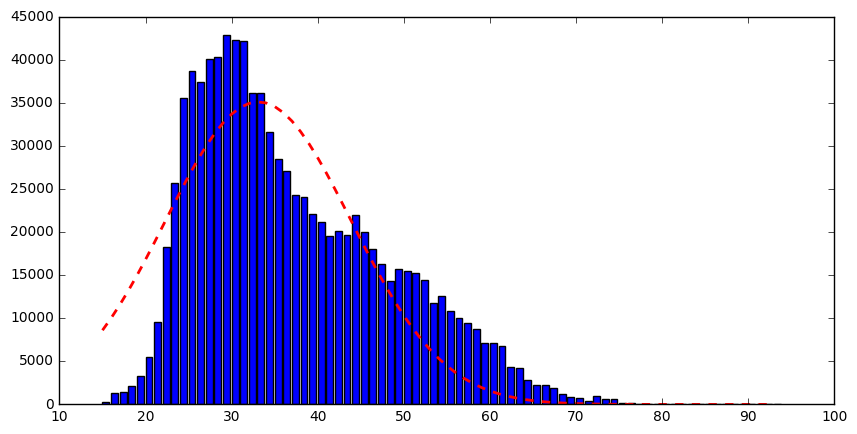

In [33]:
# plotting the distribution and the gaussian fit. 

start = 15 # non-inclusiv
end = 95 # inclusiv
step = 1

bins = np.arange(start, end, step)
AGEdist = np.array(df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero]))

pl.figure(figsize=(10, 5))
pl.bar(np.arange(start, end-step, step), AGEdist)

# fitting a normal distribution
# adapted from http://stackoverflow.com/questions/17779316/un-normalized-gaussian-curve-on-histogram
def f(x, a, b, c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

x = np.arange(start, end - step, step)
y = AGEdist[:,0]

popt, pcov = optimize.curve_fit(f, x, y, p0=(50000, np.mean(df.age), np.std(df.age))) # p0 = initial guess

y_fit = f(x, *popt) 

# plotting the corresponding normal distribution
pl.plot(x, y_fit, 'r--', linewidth=2)


## KS test for a Normal Distribution

Measures the maximum difference in the Cumulative Distribution Function, optimizing the bins for that analysis. This test is especially sensitive to differences in the mean/median region. 

$H_0:$ the sample does come from a normal distribution.

$H_a:$ the sample does not come from a normal distribution.

$\alpha = 0.05$

In [34]:
# KS test for Normal
ks_n = stats.kstest(df.age, 'norm', args=(df.age.mean(), df.age.std()))
print ks_n


KstestResult(statistic=0.1130707407354577, pvalue=0.0)


Since the p-value is much lower than $\alpha$, the Null hypothesis can be rejected. It is noteworthy, though, that because the number of observations is so large, any minimal deviation from the normal distribution (especially in the mean region) would be considered significant by this test (since having so many observations make us know our distribution so well). 

## AD Test for a Normal distribution

Similar to the KS test, in the sense that it accounts for the differences in the Cumulative Distribution Function, but adapted to give more similar weights to center and tails of the distribution. Therefore, this is a better test when we want to analyze the shape of a given distribution and are not so concerned about the exact value of the mean/median.

$H_0:$ the sample does come from a normal distribution.

$H_a:$ the sample does not come from a normal distribution.

$\alpha = 0.05$

In [35]:
# AD Test for Normal

ad_n = stats.anderson(df.age, dist = 'norm')

print ad_n

AndersonResult(statistic=16665.695014858968, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


Since AD-statistic (16665.7) is much higher than the corresponding value of $\alpha$ (0.787), we can reject the Null Hypothesis. Similarly to the KS test result, the large number of observations makes so that we know very well our distribution. Therefore, any minimal deviation from the normal distribution would be be statistically significant.  

## KL Test for a Normal distribution

This test measures KL divergence, which is a representation of how much information is lost when we model a given sample (distribution) using another given sample (distribution). 
It is important to notice that since the test doesn't assume any given analytical distribution (or paramenters), it doesn't return any p-values or statistics. Therefore the test is much more useful to compare the goodness of fit in relative terms, i. e. to compare the goodness of fit of two different distribution (e. g. Normal and Lognormal). Besides that, it is not applicable to formulate a null and alternative hypotheses for this test, but it is still a measure of the goodness of fit. Although more useful only in relative and not in absolute terms. 

In [36]:
# KL
# for KL we have to simulate and normalize the normal distribution from the histogram
distpdf_n, mybins_n, = np.histogram(df.age, bins = np.arange(start, end, step), density=True)
bincenters_n = mybins_n[:-1] + 0.5*(mybins_n[1] - mybins_n[0])

kl_n =  stats.entropy(distpdf_n, stats.norm.pdf(bincenters_n) + df.age.mean())

print kl_n

0.647103452953


As mentioned above, the result is just an indication of the loss of information when using a normal distribution to fit the data and thus, the goodness of fit. A more meaningful analysis can be done when comparing the KL result for the normal distribution with the result for another distribution. 

## KS Test for a Lognormal distribution

$H_0:$ the sample does come from a lognormal distribution.

$H_a:$ the sample does not come from a lognormal distribution.

$\alpha = 0.05$

In [37]:
#KS test for Lognormal

ks_logn = stats.kstest(df.age, 'lognorm', args=(df.age.mean(), df.age.std()))
print ks_logn



KstestResult(statistic=0.51846921847048077, pvalue=0.0)


Since the p-value is much lower than $\alpha$, the Null hypothesis can be rejected. It is noteworthy, though, that because the number of observations is so large, any minimal deviation from the lognormal distribution (especially in the center) would be considered significant by this test (since having so many observations make us know our distribution so well). 

## KL Test for a Lognormal distribution


In [38]:
# KL Test for Lognormal
distpdf_n, mybins_n, = np.histogram(df.age, bins = np.arange(start, end, step), density=True)
bincenters_n = mybins_n[:-1] + 0.5*(mybins_n[1] - mybins_n[0])

print stats.entropy(distpdf_n, stats.lognorm.pdf(bincenters_n, df.age.mean(), df.age.std()))

0.619351910829


The KL result is an indication of the information loss when fitting our data with a lognormal distribution. Through this test, we can compare which type of distribution better fit our data, the Normal or the Lognormal: Since the KL value is lower for the Lognormal distribution than for the Normal distribution, we can conclude that the Lognormal distribution is a better representation of our data than the Normal distribution.  

## KS Test for a Gumbel - L distribution

$H_0:$ the sample does come from a Gumbel-L distribution.

$H_a:$ the sample does not come from a Gumbel-L distribution.

$\alpha = 0.05$

In [43]:
#KS test for Gumbel-L

ks_gumb = stats.kstest(df.age, 'gumbel_l', args=(df.age.mean(), df.age.std()))
print ks_gumb


KstestResult(statistic=0.2097219021581242, pvalue=0.0)


Since the p-value is much lower than $\alpha$, the Null hypothesis can be rejected. It is noteworthy, though, that because the number of observations is so large, any minimal deviation from the gumbel-L distribution (especially in the center) would be considered significant by this test (since having so many observations make us know our distribution so well). 

## KL Test for a Gumbel-L distribution


In [40]:
# KL Test for Gumbel-L

distpdf_n, mybins_n, = np.histogram(df.age, bins = np.arange(start, end, step), density=True)
bincenters_n = mybins_n[:-1] + 0.5*(mybins_n[1] - mybins_n[0])

print stats.entropy(distpdf_n, stats.gumbel_l.pdf(bincenters_n, df.age.mean(), df.age.std()))

0.410052615138


The KL result is an indication of the information loss when fitting our data with a Gumbel-L distribution. Through this test, we can compare which type of distribution better fit our data, the Normal or the Lognormal or the Gumbel-L: Since the KL value for the Gumbel-L distribution is lower than for the Normal and the Lognormal distribution, we can conclude that the Gumbel-L distribution is a better representation of our data than the Lognormal and the Normal distribution.  